In [1]:
!pip -q install mrjob pandas matplotlib nltk

In [2]:
import pandas as pd

In [3]:
%%file bigramcount.py
from mrjob.job import MRJob, MRStep
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

class MRBigramFrequency(MRJob):

    def mapper_init(self):
        
        import nltk
        nltk.download('punkt')
        nltk.download('stopwords')
        # self.stop_words = set(stopwords.words('english'))

    def mapper(self, _, line):
        
        stop_words = set(stopwords.words('english'))
        words = (line.lower()) \
            .replace("(", '').replace(")", '').replace("!", '') \
            .replace(".", '').replace(",", '').replace("'", '') \
            .replace("?", '').replace('"', '').split()[1:]

        person = words[0]
        phrase = ' '.join(words[1:])

        cleaned_tokens = [word for word in word_tokenize(phrase) if word not in stop_words]

        bigrams = [(cleaned_tokens[i], cleaned_tokens[i + 1]) for i in range(len(cleaned_tokens) - 1)]
        for bigram in bigrams:
            yield bigram, 1

    def reducer(self, bigram, counts):
        total_count = sum(counts)

        yield bigram, total_count

    def mapper_top20(self, bigram, count):
        yield (None, (count, bigram))

    def reducer_top20(self, _, count_bigram_pairs):
        top20 = sorted(count_bigram_pairs, reverse=True)[:20]
        for count, bigram in top20:
            yield (bigram, count)

    def steps(self):
        return [
            MRStep(mapper_init=self.mapper_init, mapper=self.mapper, reducer=self.reducer),
            MRStep(mapper=self.mapper_top20, reducer=self.reducer_top20)
        ]

if __name__ == '__main__':
    MRBigramFrequency.run()


Overwriting bigramcount.py


In [4]:
!python3 bigramcount.py SW_EpisodeIV.txt > out31.csv

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/bigramcount.root.20231129.132024.405753
Running step 1 of 2...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Dow

In [5]:
!python3 bigramcount.py SW_EpisodeV.txt > out32.csv

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/bigramcount.root.20231129.132026.351369
Running step 1 of 2...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Dow

In [6]:
!python3 bigramcount.py SW_EpisodeVI.txt > out33.csv

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/bigramcount.root.20231129.132027.996250
Running step 1 of 2...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Dow

In [7]:
df1 = pd.read_csv('out31.csv', sep='\t', names=['bigram', 'count'], index_col=['bigram'])
df2 = pd.read_csv('out32.csv', sep='\t', names=['bigram', 'count'], index_col=['bigram'])
df3 = pd.read_csv('out33.csv', sep='\t', names=['bigram', 'count'], index_col=['bigram'])

Построим графики для каждого эпизода

<Axes: xlabel='bigram'>

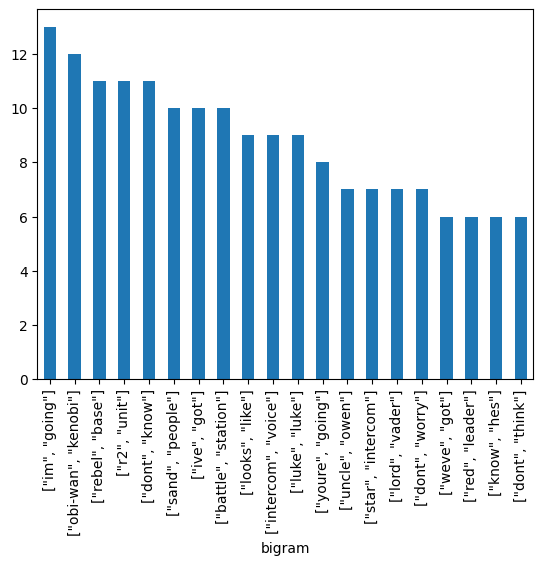

In [8]:
df1['count'].sort_values(ascending=False)[:20].plot(kind='bar')

<Axes: xlabel='bigram'>

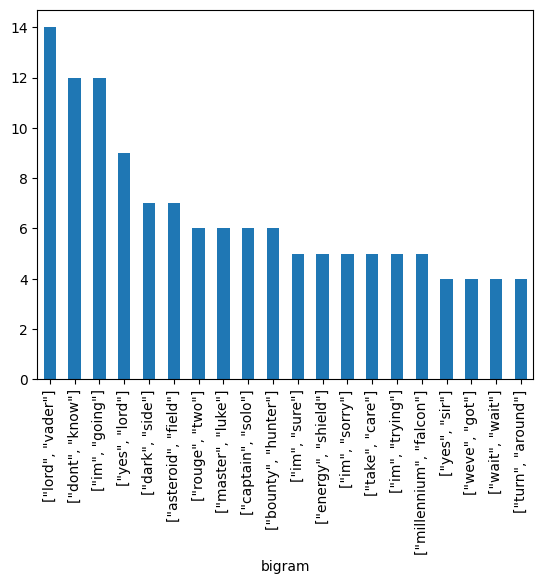

In [9]:
df2['count'].sort_values(ascending=False)[:20].plot(kind='bar')

<Axes: xlabel='bigram'>

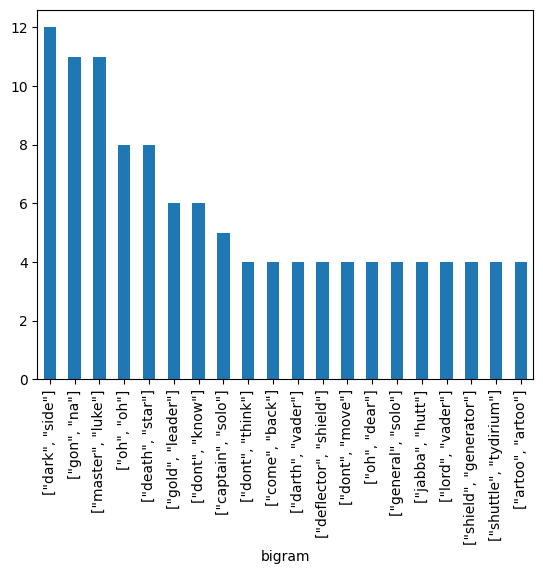

In [10]:
df3['count'].sort_values(ascending=False)[:20].plot(kind='bar')

Построим график для всех эпизодов

<Axes: xlabel='bigram'>

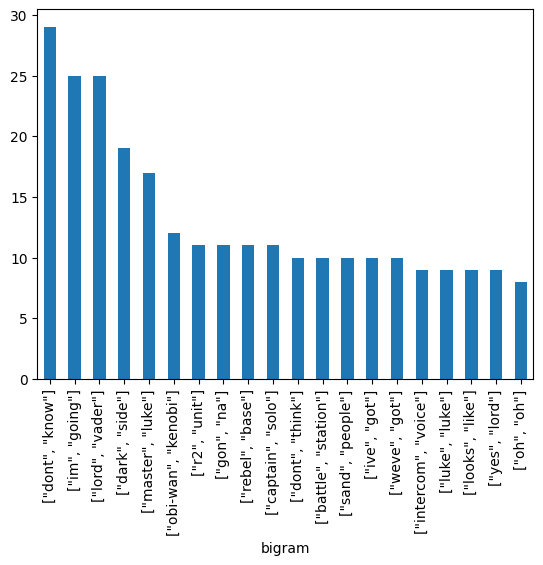

In [11]:
concatenated_df = pd.concat([df1, df2, df3])
result_df = concatenated_df.groupby(concatenated_df.index)['count'].sum()
result_df.sort_values(ascending=False)[:20].plot(kind='bar')

Как и в жизни, никто ничего не знает)

Теперь посчитаем на кластере

In [12]:
%%file config.conf

runners:
  hadoop: # also works for emr runner
    setup:
        'pip install nltk'
    jobconf:
      mapreduce.job.reduces: 2

Overwriting config.conf


In [13]:
!hdfs dfsadmin -safemode leave

Safe mode is OFF


In [14]:
!python3 bigramcount.py -r hadoop hdfs://namenode:8020/hw1/SW_EpisodeIV.txt --conf-path config.conf --output /hw1/output31

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 3.3.6
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.6.jar
Creating temp directory /tmp/bigramcount.root.20231129.132034.008814
uploading working dir files to hdfs:///user/root/tmp/mrjob/bigramcount.root.20231129.132034.008814/files/wd...
Copying other local files to hdfs:///user/root/tmp/mrjob/bigramcount.root.20231129.132034.008814/files/
Running step 1 of 2...
  packageJobJar: [/tmp/hadoop-unjar4105878069234046163/] [] /tmp/streamjob2043479252997032288.jar tmpDir=null
  Connecting to ResourceManager at resourcemanager/172.21.0.4:8032
  Connecting to ResourceManager at resourcemanager/172.21.0.4:8032
  Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1700575720544_0043
  Total input files to process : 1
  number of splits:2
  Submitting tokens for job: job_1

In [15]:
!hadoop fs -cat /hw1/output31/part-00000

["im", "going"]	13
["obi-wan", "kenobi"]	12
["rebel", "base"]	11
["r2", "unit"]	11
["dont", "know"]	11
["sand", "people"]	10
["ive", "got"]	10
["battle", "station"]	10
["luke", "luke"]	9
["looks", "like"]	9
["intercom", "voice"]	9
["youre", "going"]	8
["uncle", "owen"]	7
["star", "intercom"]	7
["lord", "vader"]	7
["dont", "worry"]	7
["weve", "got"]	6
["red", "leader"]	6
["know", "hes"]	6
["dont", "think"]	6


Остальные вычисления выполняются аналогично

In [16]:
!python3 bigramcount.py -r hadoop hdfs://namenode:8020/hw1/SW_EpisodeV.txt --conf-path config.conf --output /hw1/output32

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 3.3.6
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.6.jar
Creating temp directory /tmp/bigramcount.root.20231129.132220.010721
uploading working dir files to hdfs:///user/root/tmp/mrjob/bigramcount.root.20231129.132220.010721/files/wd...
Copying other local files to hdfs:///user/root/tmp/mrjob/bigramcount.root.20231129.132220.010721/files/
Running step 1 of 2...
  packageJobJar: [/tmp/hadoop-unjar7083699401715568445/] [] /tmp/streamjob7093428017346455255.jar tmpDir=null
  Connecting to ResourceManager at resourcemanager/172.21.0.4:8032
  Connecting to ResourceManager at resourcemanager/172.21.0.4:8032
  Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1700575720544_0045
  Total input files to process : 1
  number of splits:2
  Submitting tokens for job: job_1

In [17]:
!hadoop fs -cat /hw1/output32/part-00000

["lord", "vader"]	14
["im", "going"]	12
["dont", "know"]	12
["yes", "lord"]	9
["dark", "side"]	7
["asteroid", "field"]	7
["rouge", "two"]	6
["master", "luke"]	6
["captain", "solo"]	6
["bounty", "hunter"]	6
["take", "care"]	5
["millennium", "falcon"]	5
["im", "trying"]	5
["im", "sure"]	5
["im", "sorry"]	5
["energy", "shield"]	5
["yes", "sir"]	4
["weve", "got"]	4
["wait", "wait"]	4
["turn", "around"]	4


In [18]:
!python3 bigramcount.py -r hadoop hdfs://namenode:8020/hw1/SW_EpisodeVI.txt --conf-path config.conf --output /hw1/output33

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 3.3.6
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.6.jar
Creating temp directory /tmp/bigramcount.root.20231129.132407.212352
uploading working dir files to hdfs:///user/root/tmp/mrjob/bigramcount.root.20231129.132407.212352/files/wd...
Copying other local files to hdfs:///user/root/tmp/mrjob/bigramcount.root.20231129.132407.212352/files/
Running step 1 of 2...
  packageJobJar: [/tmp/hadoop-unjar8836567507969848146/] [] /tmp/streamjob5523212867010993093.jar tmpDir=null
  Connecting to ResourceManager at resourcemanager/172.21.0.4:8032
  Connecting to ResourceManager at resourcemanager/172.21.0.4:8032
  Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1700575720544_0047
  Total input files to process : 1
  number of splits:2
  Submitting tokens for job: job_1

In [19]:
!hadoop fs -cat /hw1/output33/part-00000

["dark", "side"]	12
["master", "luke"]	11
["gon", "na"]	11
["oh", "oh"]	8
["death", "star"]	8
["gold", "leader"]	6
["dont", "know"]	6
["captain", "solo"]	5
["shuttle", "tydirium"]	4
["shield", "generator"]	4
["oh", "dear"]	4
["lord", "vader"]	4
["jabba", "hutt"]	4
["general", "solo"]	4
["dont", "think"]	4
["dont", "move"]	4
["deflector", "shield"]	4
["darth", "vader"]	4
["come", "back"]	4
["artoo", "artoo"]	4
